In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.contrib.eager as tfe
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
sns.set(color_codes=True)
import os
%matplotlib inline
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
tf.enable_eager_execution()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Import the dataset

In [3]:
df  = pd.read_csv('Data/lorenz.csv', delimiter = ',')
df = df.drop_duplicates()
df.head()

,time,x,y,z
0,1.0,0.100000,0.000000,0.000000
1,1.1,0.127219,0.255423,0.001143
2,1.2,0.394824,0.859452,0.012868
3,1.3,1.285241,2.802134,0.137016
4,1.4,4.154179,8.964425,1.436762


In [0]:
split_size = 5000
names = list(df.columns)

,time,x,y,z
time,1.000000,0.090482,0.079838,-0.013209
x,0.090482,1.000000,0.880964,-0.007791
y,0.079838,0.880964,1.000000,-0.007034
z,-0.013209,-0.007791,-0.007034,1.000000


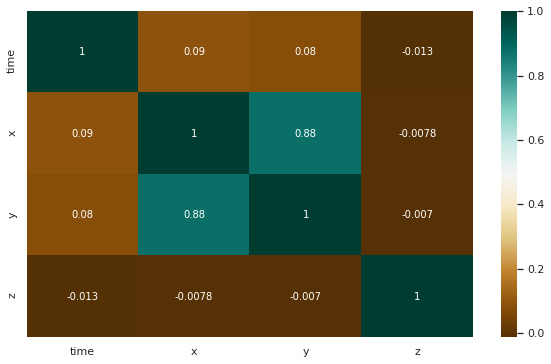

In [6]:
plt.figure(figsize=(10,6))
c= df.corr()
sns.heatmap(c,cmap="BrBG",annot=True)
c

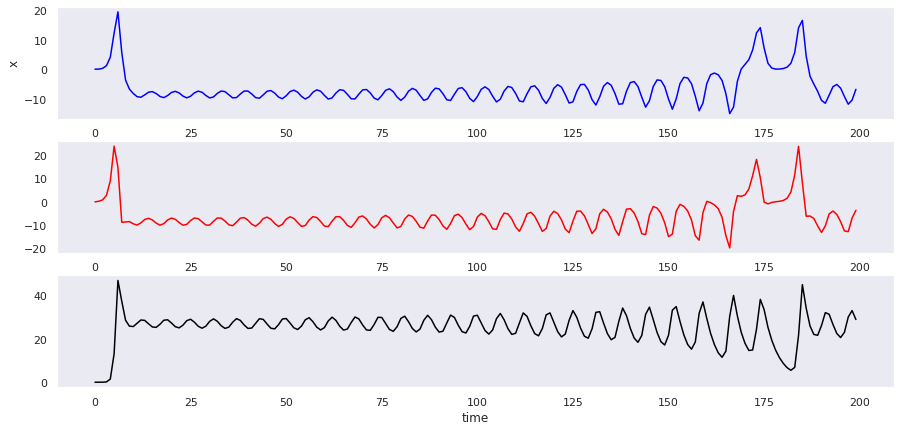

In [7]:
x = df['x']
y = df['y']
z = df['z']
plt.figure(figsize=(15,7))
plt.subplot(311)
plt.plot(x[:200], color='blue')
plt.ylabel('x')
plt.subplot(312)
plt.plot(y[:200], color='red')
plt.subplot(313)
plt.plot(z[:200], color='black')
plt.xlabel('time')
plt.show()

In [0]:
tf.compat.v1.set_random_seed(10)   

In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

In [0]:
# use tf.data to shuffle data
BATCH_SIZE = 256
BUFFER_SIZE = 10000

In [0]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mean_squared_error')

In [0]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

Multivariate time forecasting

In [12]:
features = ['x', 'y', 'z']
dataset = df[features]
dataset.index = df['time']
dataset.head()

,x,y,z
time,,,
1.0,0.100000,0.000000,0.000000
1.1,0.127219,0.255423,0.001143
1.2,0.394824,0.859452,0.012868
1.3,1.285241,2.802134,0.137016
1.4,4.154179,8.964425,1.436762


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f56d9d5e828>,
      dtype=object)

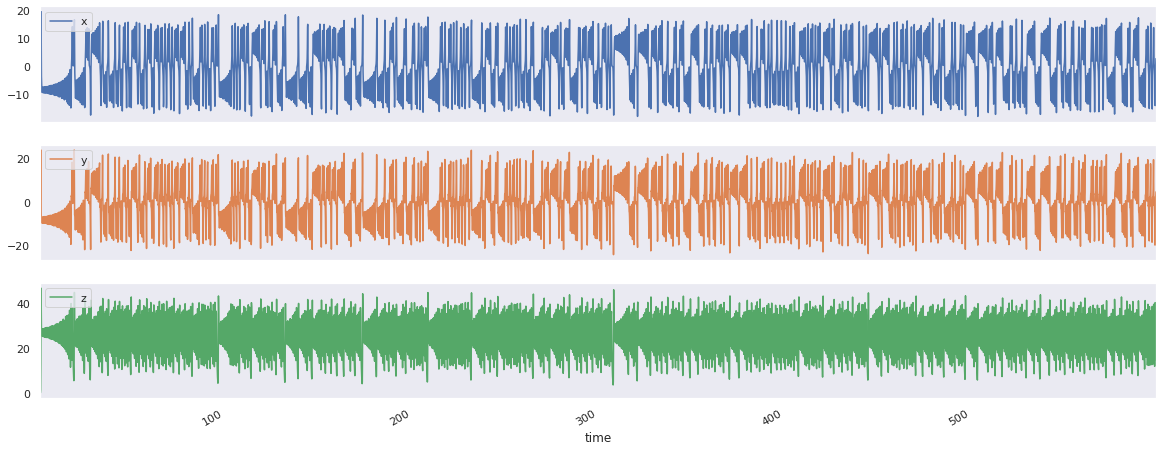

In [14]:
dataset.plot(subplots=True, figsize=(20,8))

In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

Again standardize the whole dataset

In [0]:
data = dataset.values
data_mean = data[:split_size].mean(axis=0)
data_std = data[:split_size].std(axis=0)
data = (data-data_mean)/data_std

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [0]:
past_history = 720 
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(data, data[:, 1], 0,
                                                   split_size, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(data, data[:, 1],
                                               split_size, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [0]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [0]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mean_squared_error')

In [27]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
200/200 [==============================] - 43s 214ms/step - loss: 0.9985 - val_loss: 1.0020
Epoch 2/10
200/200 [==============================] - 40s 199ms/step - loss: 0.9892 - val_loss: 1.0193
Epoch 3/10
200/200 [==============================] - 40s 199ms/step - loss: 0.9768 - val_loss: 1.0696
Epoch 4/10
200/200 [==============================] - 40s 200ms/step - loss: 0.9592 - val_loss: 1.0858
Epoch 5/10
200/200 [==============================] - 40s 199ms/step - loss: 0.9513 - val_loss: 1.0899
Epoch 6/10
200/200 [==============================] - 40s 200ms/step - loss: 0.9433 - val_loss: 1.1195
Epoch 7/10
200/200 [==============================] - 40s 201ms/step - loss: 0.9360 - val_loss: 1.1157
Epoch 8/10
200/200 [==============================] - 40s 200ms/step - loss: 0.9225 - val_loss: 1.1317
Epoch 9/10
200/200 [===================

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

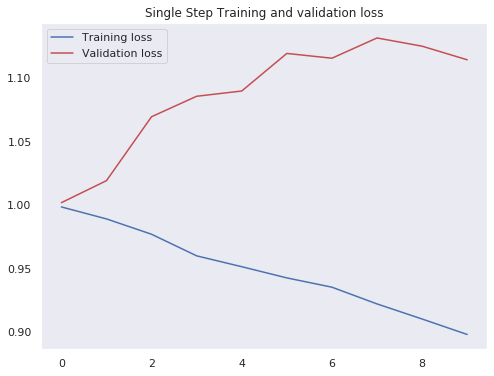

In [29]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

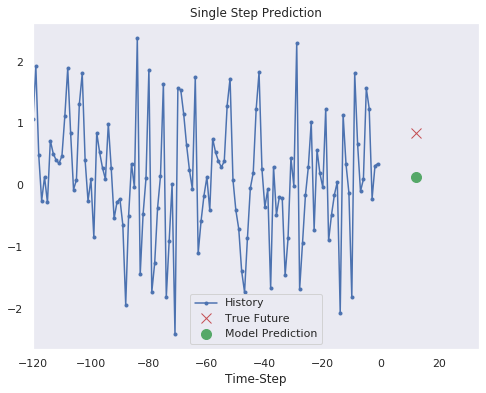

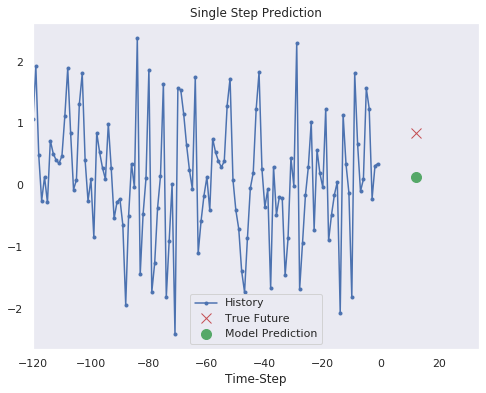

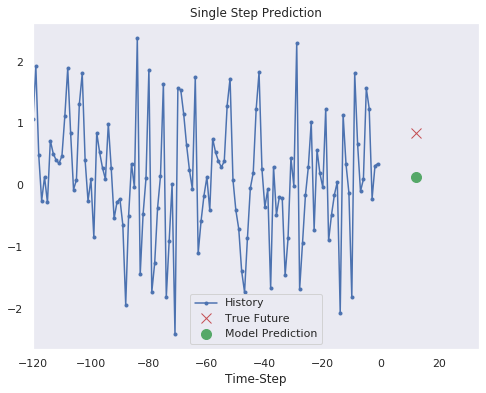

In [35]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

Multistep prediction

In [0]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(data, data[:, 1], 0,
                                                 split_size, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(data, data[:, 1],
                                             split_size, None, past_history,
                                             future_target, STEP)

In [0]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [0]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

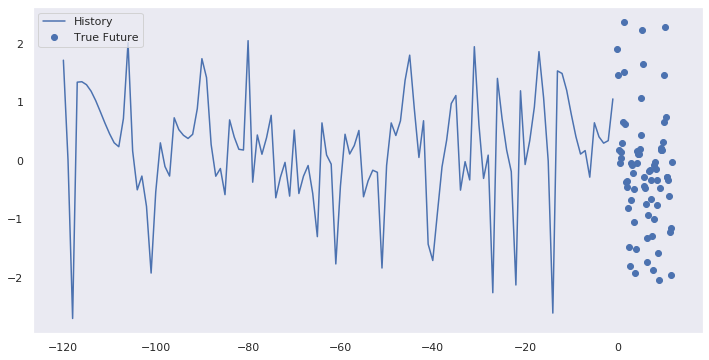

In [39]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [0]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mean_squared_error')

In [41]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 79s 396ms/step - loss: 0.9978 - val_loss: 1.0134
Epoch 2/10
200/200 [==============================] - 75s 376ms/step - loss: 81709109181.2297 - val_loss: 1.0274
Epoch 3/10
200/200 [==============================] - 75s 376ms/step - loss: 0.9658 - val_loss: 1.0338
Epoch 4/10
200/200 [==============================] - 75s 377ms/step - loss: 0.9640 - val_loss: 1.0356
Epoch 5/10
200/200 [==============================] - 76s 379ms/step - loss: 457776657614.6074 - val_loss: 1.0157
Epoch 6/10
200/200 [==============================] - 75s 377ms/step - loss: 1605938.7010 - val_loss: 1.0137
Epoch 7/10
200/200 [==============================] - 75s 374ms/step - loss: 0.9796 - val_loss: 1.0173
Epoch 8/10
200/200 [==============================] - 74s 371ms/step - loss: 0.9829 - val_loss: 1.0164
Epoch 9/10
200/200 [==============================] - 74s 372ms/step - loss: 128264.7879 - val_loss: 1.031

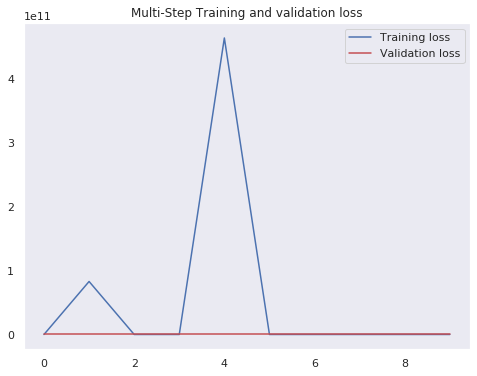

In [42]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

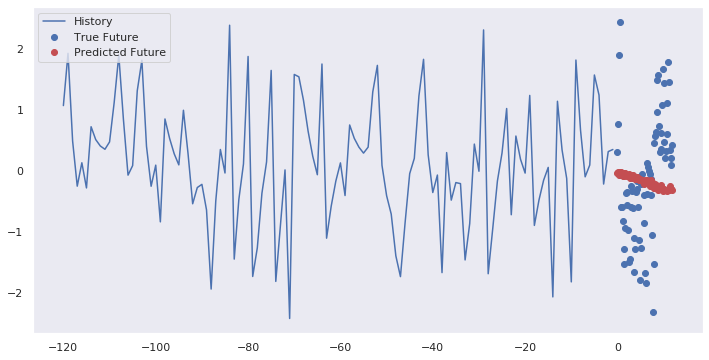

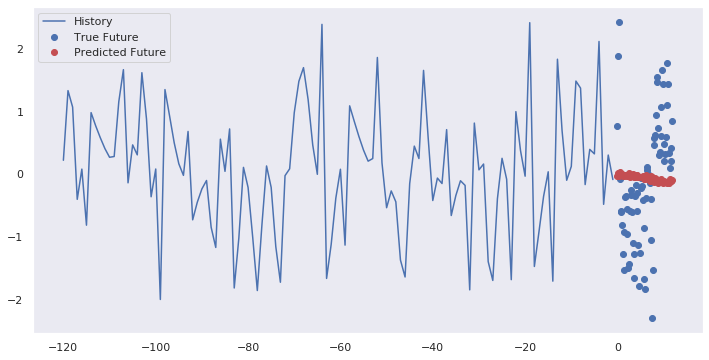

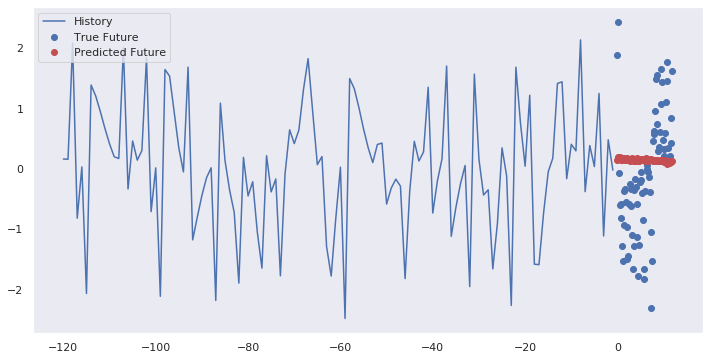

In [43]:
for x, y in val_data_multi.take(1):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])
  multi_step_plot(x[1], y[1], multi_step_model.predict(x)[1])
  multi_step_plot(x[2], y[2], multi_step_model.predict(x)[2])